In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML



import warnings

import numpy as np
import pandas as pd
import copy
import random

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

warnings.filterwarnings(action='once')


In [46]:
# function to create filtered dataframe and align timeseries to that start of the spread

def create_filtered_data(df, threshold):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    for location in df.columns:
        if(pattern.search(location)):
            continue
        highnumber = df[df[location].gt(threshold)]
        if(len(highnumber)>0):
            newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
    return newdf

# function to build and plot synthetic control baswed projections. The first threshold is which regions to use in the donor pool 
# - the ones that have had the timeseries for threshold days and above. The low_thresh is to do predictions for regions that
# have had the spread for at least low_thresh days but below threshold days

# for i in range(20):
#    synth_control_predictions2(trial,35,5+i, "Rolling 5-day average deaths data", 2, ylimit=[], savePlots=False, do_only=target, showstates=12,
#                               exclude=exclude1, animation=camera)
 
def synth_control_predictions2(df, threshold, low_thresh,  title_text, singVals=2, 
                               savePlots=False, ylimit=[], logy=False, exclude=[], 
                               svdSpectrum=False, do_only=[], showstates=4, animation=[], donorPool=[]):
    sizes = df.apply(pd.Series.last_valid_index)
    sizes = sizes.fillna(0).astype(int)
    
    if (donorPool):
        otherStates=donorPool
    else:
        otherStates = list(sizes[sizes>threshold].index)
    if(exclude):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
    if(do_only):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
        for member in do_only:
            if(member in otherStates):
                otherStates.remove(member)
            
    
    showstates = np.minimum(showstates,len(otherStates))
    otherStatesNames = otherStates
    otherStatesNames = [w.replace('-None', '') for w in otherStates]
    for state in otherStatesNames:
        state.replace("-None","")
    print(otherStates)
    if(do_only):
        prediction_states = list(sizes[sizes.index.isin(do_only)].index)
        print(prediction_states)
    else:
        prediction_states = list(sizes[(sizes>low_thresh) & (sizes<=threshold)].index)
    
    
    for state in prediction_states:
        trainDF=df.iloc[:low_thresh,:]
        print(trainDF.shape)

        testDF=df.iloc[low_thresh+1:threshold,:]
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []
    
        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        x_actual=range(sizes[state])
        actual = df.iloc[:sizes[state],:][state]
        
        #plt.plot(x_actual,actual,label='Actuals', color='k')
        if (svdSpectrum):
            all_rows = list.copy(otherStates)
            all_rows.append(state)
            (U, s, Vh) = np.linalg.svd((trainDF[all_rows]) - np.mean(trainDF[all_rows]))
            s2 = np.power(s, 2)
            plt.figure(figsize=(8,6))

            #plt.yscale('log')
            plt.plot(s2)
            plt.grid()
            plt.xlabel("Ordered Singular Values") 
            plt.ylabel("Energy")
            plt.title("Singular Value Spectrum")
            plt.show()
        x_predictions=range(low_thresh,low_thresh+len(predictions))
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        #print(list(zip(otherStatesNames, rscModel.model.weights/np.max(rscModel.model.weights))))
        
        if not animation:
            plt.figure(figsize=(16,6))
        
        
        
        plt.subplot(121)
        ind = np.argpartition(rscModel.model.weights, -showstates)[-showstates:]
        topstates = [otherStates[i] for i in ind]
        #plt.barh(topstates, rscModel.model.weights[ind]/np.max(rscModel.model.weights), color=list('rgbkymc'))
        plt.barh(otherStates, rscModel.model.weights/np.max(rscModel.model.weights), color=list('rgbkymc'))
        plt.title("Normalized weights for "+str(state).replace("-None",""))

        #plt.show()
        plt.subplot(122)
        
        if(ylimit):
            plt.ylim(ylimit)
        if(logy):
            plt.yscale('log')
        
        plt.plot(x_actual,actual,label='Actuals', color='k', linestyle='-')
        plt.plot(x_predictions,predictions,label='Predictions', color='r', linestyle='--')
        plt.plot(range(len(model_fit)), model_fit, label = 'Fitted model', color='g', linestyle=':')
        plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
        plt.title(title_text+" for "+str(state).replace("-None",""))
        plt.xlabel("Days Since 10 deaths")
        plt.ylabel("Deaths")
        plt.legend(['Actuals', 'Predictions', 'Fitted Model'])
        plt.grid()
        if (savePlots):
            plt.savefig("../Figures/COVID/"+state+".png")
        
        
        if(animation):
            animation.snap()

        else:
            plt.show()
    return(topstates)
        
        
        
#global settings for graphs        
cc = (cycler(color=list('rgbcmyk')) *
      cycler(linestyle=['-', '--', '-.',':']))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)

In [3]:
usstates = pd.read_csv("../COVID/covid-19-data/us-states.csv")
uscounties = pd.read_csv("../COVID/covid-19-data/us-counties.csv")
uscounties['county_state']=uscounties['county']+'-'+uscounties['state']
uscases = usstates.pivot(index='date', columns='state', values='cases')
usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
uscounties_deaths = uscounties.pivot_table(index='date', columns='county_state', values='deaths')
uscounties_cases = uscounties.pivot_table(index='date', columns='county_state', values='cases')
global_covid = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
us_covid_jhu = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
global_covid_cases = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
global_covid['Province-Country']=global_covid['Country/Region']+'-'+global_covid['Province/State'].fillna("None")
global_covid['Province-Country'] = global_covid['Province-Country'].str.replace("-None","")
global_covid=global_covid.set_index('Province-Country')
global_deaths = global_covid.loc[:,'1/22/20':].T

global_covid_cases['Province-Country']=global_covid_cases['Country/Region']+'-'+global_covid_cases['Province/State'].fillna("")
global_covid_cases=global_covid_cases.set_index('Province-Country')
global_cases = global_covid_cases.loc[:,'1/22/20':].T

#us_covid_jhu['Province-Country']=global_covid['Country/Region']+'-'+global_covid['Province/State'].fillna("None")
us_covid_jhu=us_covid_jhu.set_index('Combined_Key')
us_covid_jhu_deaths = us_covid_jhu.loc[:,'1/22/20':].T

global_country_aggr = global_covid.groupby('Country/Region').sum()


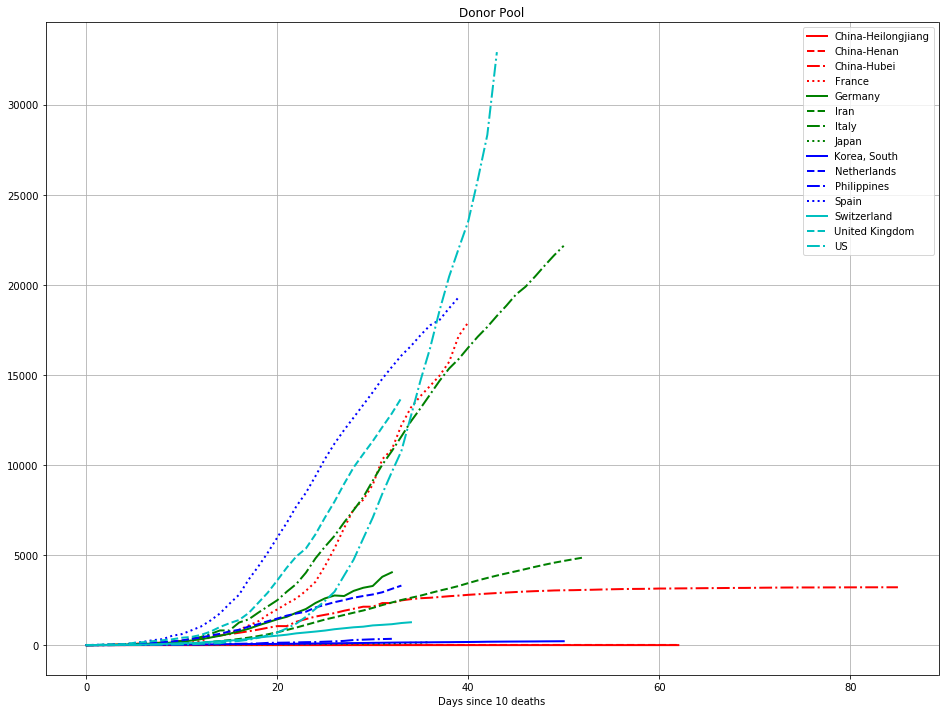

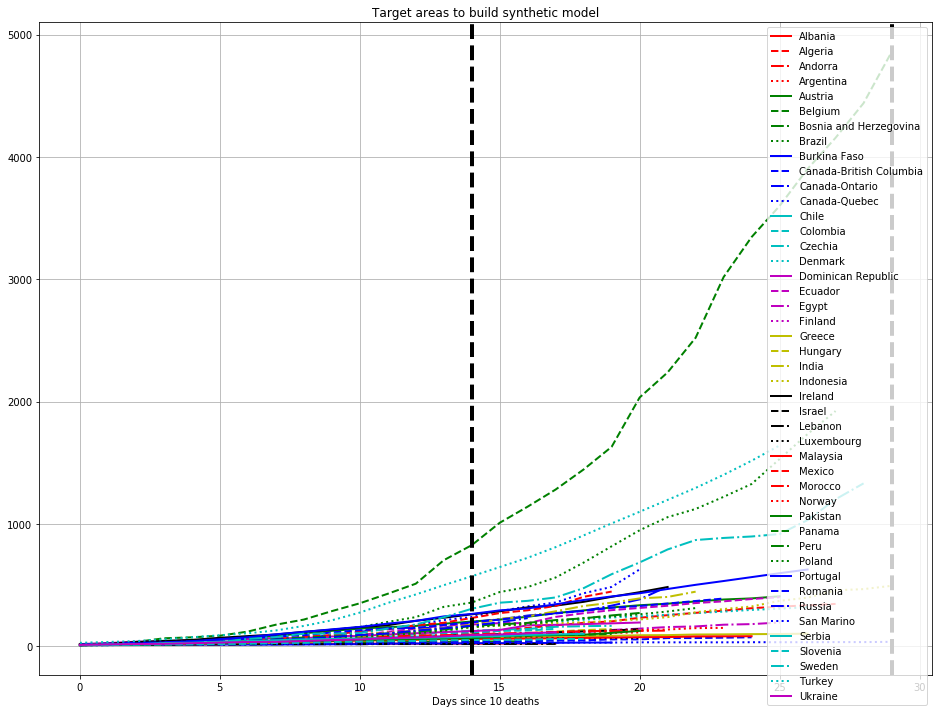

In [4]:
global_deaths_filtered = create_filtered_data(global_deaths, 10 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=15
threshold=30
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot(figsize=(16,12), grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(figsize=(16,12), grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [5]:
rolling_average_duration = 3

daily_global = create_filtered_data(global_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = create_filtered_data(usdeaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [6]:
sd_data = pd.read_csv("../data/sdc_sources.csv")
for index, row in sd_data.iterrows():
    if row['Mass gathering restrictions']=="full implementation":
        #print(row['name'])
        row['Mass gathering restrictions']=row['Stay at Home Order']
    if row['Initial business closures']=="full implementation":
        #print(row['name'])
        row['Initial business closures']=row['Non-essential services closed']

In [7]:
print(sd_data.columns)
intervention_tried = sd_data.columns[7]
print(intervention_tried)
educational_distancing = sd_data[['country','name',intervention_tried]]
educational_distancing[intervention_tried] = educational_distancing[intervention_tried].str.replace(".","-")


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited'],
      dtype='object')
Non-essential services closed


<ipython-input-7-dc1b61448d6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  educational_distancing[intervention_tried] = educational_distancing[intervention_tried].str.replace(".","-")


In [8]:
for place in educational_distancing.name:
#or place in ['Belgium', 'Finland']:
    split_values = educational_distancing[educational_distancing.name == place][intervention_tried].str.split("-").values
    #print(split_values)
    #print(place, split_values, split_values.shape)
    if(split_values):
        if(len(split_values[0])>1):
        #print(split_values[0])
        #print(place)
            educational_distancing.loc[educational_distancing.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
        else:
            print(place)
            print(educational_distancing[educational_distancing.name == place])

/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-8-1c62e76464ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

Hamburg
   country     name Non-essential services closed date
6  Germany  Hamburg               not implemented  NaN
Hesse
   country   name Non-essential services closed date
7  Germany  Hesse               not implemented  NaN
Saarland
    country      name Non-essential services closed date
12  Germany  Saarland               not implemented  NaN
Thuringia
    country       name Non-essential services closed date
16  Germany  Thuringia               not implemented  NaN
Arizona
   country     name Non-essential services closed date
40     USA  Arizona               not implemented  NaN
Arkansas
   country      name Non-essential services closed date
41     USA  Arkansas               not implemented  NaN
Florida
   country     name Non-essential services closed date
46     USA  Florida               not implemented  NaN
Georgia
   country     name Non-essential services closed date
47     USA  Georgia               not implemented  NaN
Iowa
   country  name Non-essential services c

/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-8-1c62e76464ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  educational_distancing.loc[educational_distancing.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [9]:
#us_school_closures
#educational_distancing[educational_distancing.country=="Italy"]
#educational_distancing.append({'country':'Spain', 'name':'Spain', 'date':'2020-03-14'}, ignore_index=True)

In [10]:
#usdeaths[usdeaths.index>intervention_date[0]]
newdf_global = pd.DataFrame()
for state in global_deaths.columns:
    intervention_date = educational_distancing[educational_distancing.name == state].date.values
    #print(intervention_date)
    if(intervention_date.size>0):
        #print(usdeaths[usdeaths.index>'2020-03-23'][state])
        newdata = global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])][state].values
        if(np.isnan(newdata[:5]).any()):
            print(state)
            continue
        newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state], 
                                                             data=global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])-datetime.timedelta(days=0)][state].values)], axis=1)
        newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" plus 7"], 
                                               data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) + 
                                                                 datetime.timedelta(days=7)][state].values)], axis=1)
        newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" minus 7"], 
                                               data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                 datetime.timedelta(days=7)][state].values)], axis=1)
        

In [11]:
newdf = pd.DataFrame()
for state in usdeaths.columns:
    intervention_date = educational_distancing[educational_distancing.name == state].date.values
    #print(intervention_date)
    if(intervention_date.size>0):
        newdata = usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])][state].values
        if(np.isnan(newdata[:5]).any()):
            print(state)
            continue
        #print(usdeaths[usdeaths.index>'2020-03-23'][state])
        newdf = pd.concat([newdf, pd.DataFrame(columns=[state], 
                                               data=usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])-datetime.timedelta(days=0)][state].values)], axis=1)
        newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" plus 7"], 
                                               data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) + 
                                                                 datetime.timedelta(days=7)][state].values)], axis=1)
        newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" minus 7"], 
                                               data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                 datetime.timedelta(days=7)][state].values)], axis=1)
        #newdf = pd.concat([newdf, pd.DataFrame(columns=[state+"minus 7"], data=usdeaths.loc[usdeaths.index>=intervention_date[0]-7][state].values)], axis=1)


In [ ]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [12]:
matching = [s for s in newdf_global.columns if "7" in s]
matching_us = [s for s in newdf.columns if "7" in s]

In [14]:
rolling_average_duration = 5

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

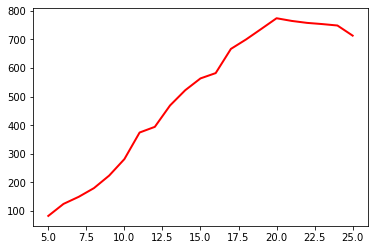

In [18]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

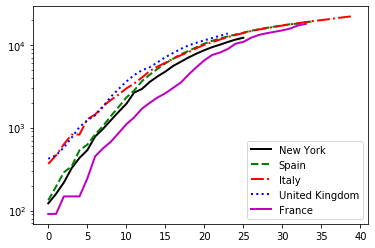

(<matplotlib.axes._subplots.AxesSubplot at 0x119f478e0>,
 <matplotlib.legend.Legend at 0x119ec3100>)

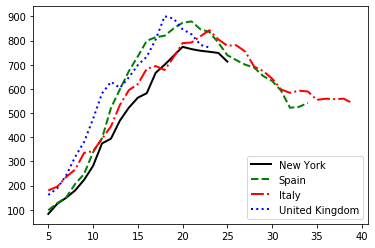

In [15]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

Ohio    24
dtype: int64
24
['China-Hubei', 'Italy']
['Ohio']
(21, 255)


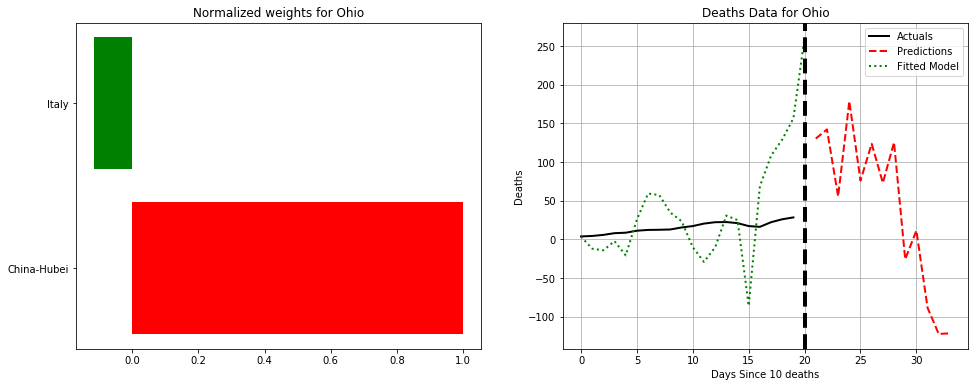

['China-Hubei', 'Italy']
['Ohio minus 7']
(21, 255)


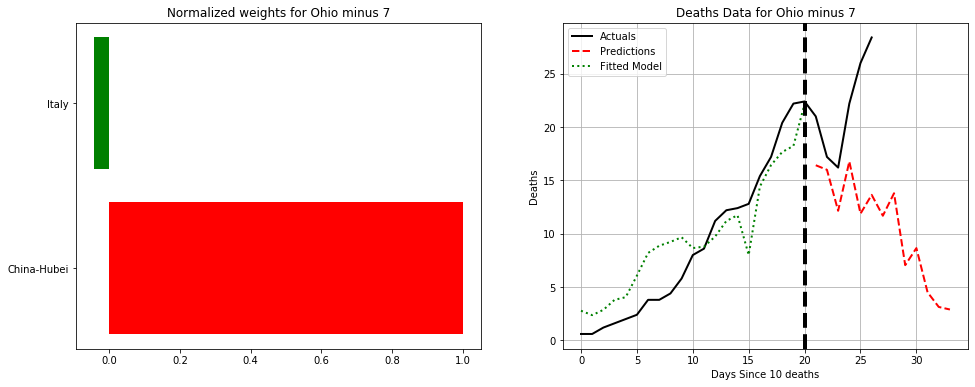

New York    25
dtype: int64
25
['China-Hubei', 'Italy']
['New York']
(21, 255)


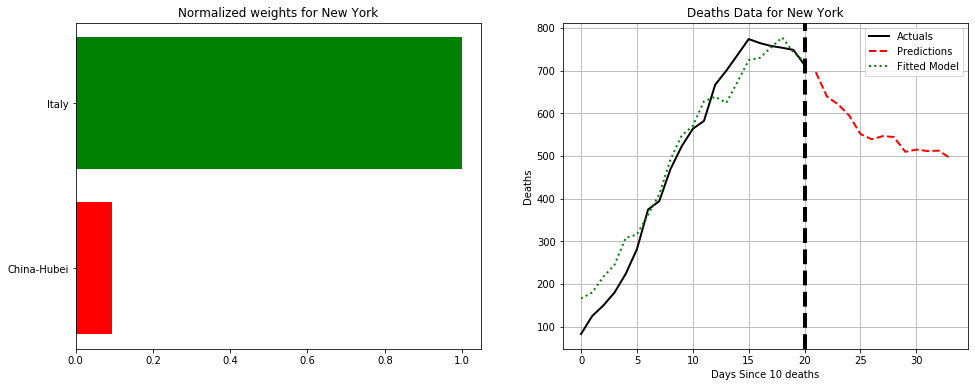

['China-Hubei', 'Italy']
['New York minus 7']
(21, 255)


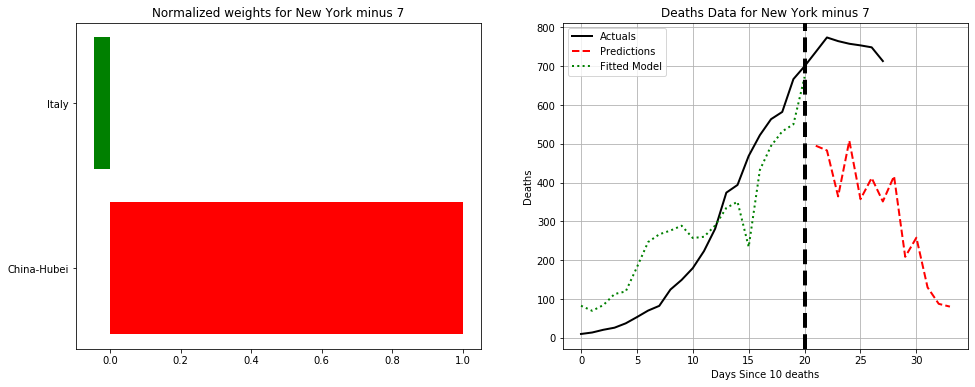

Illinois    26
dtype: int64
26
['China-Hubei', 'Italy']
['Illinois']
(21, 255)


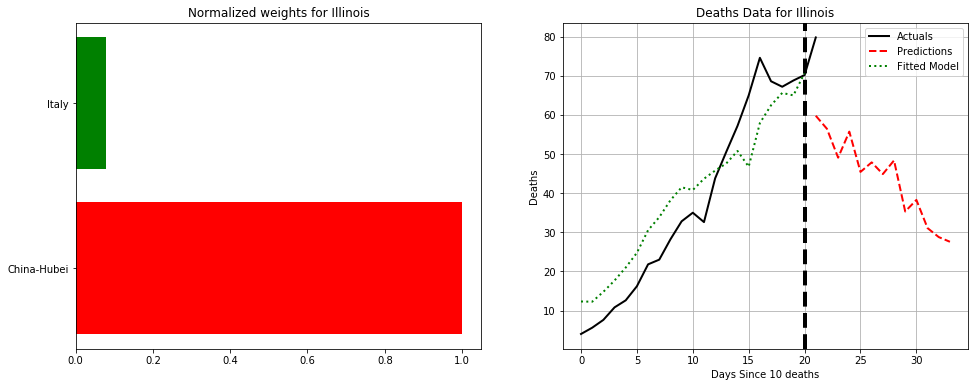

['China-Hubei', 'Italy']
['Illinois minus 7']
(21, 255)


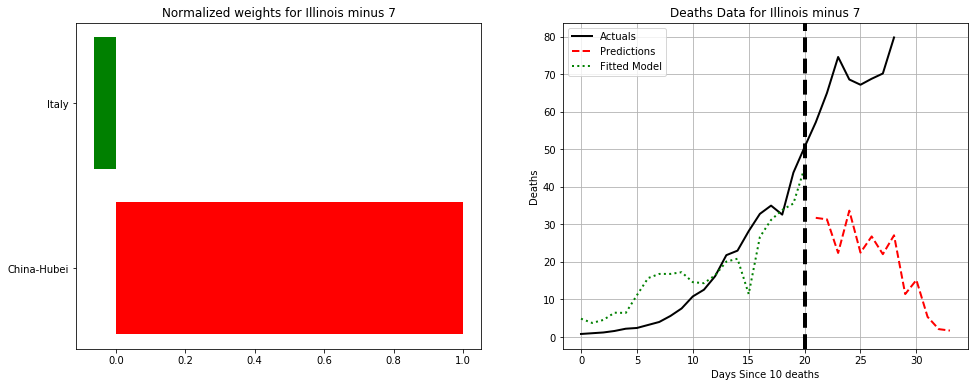

Belgium    29
dtype: int64
29
['China-Hubei', 'Italy']
['Belgium']
(21, 255)


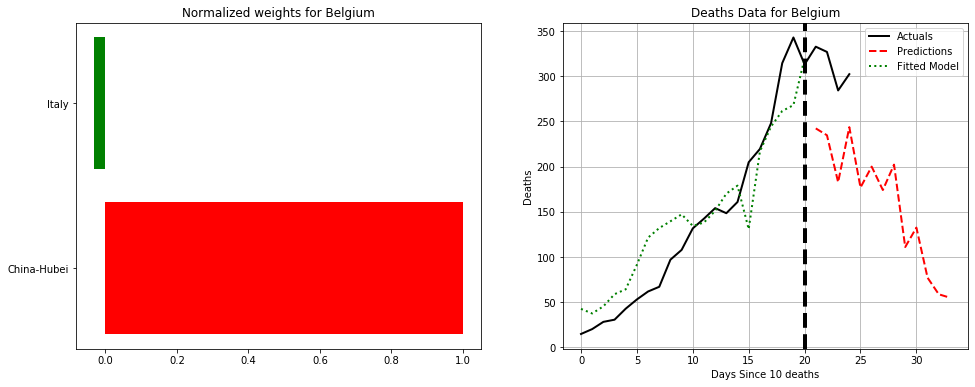

['China-Hubei', 'Italy']
['Belgium minus 7']
(21, 255)


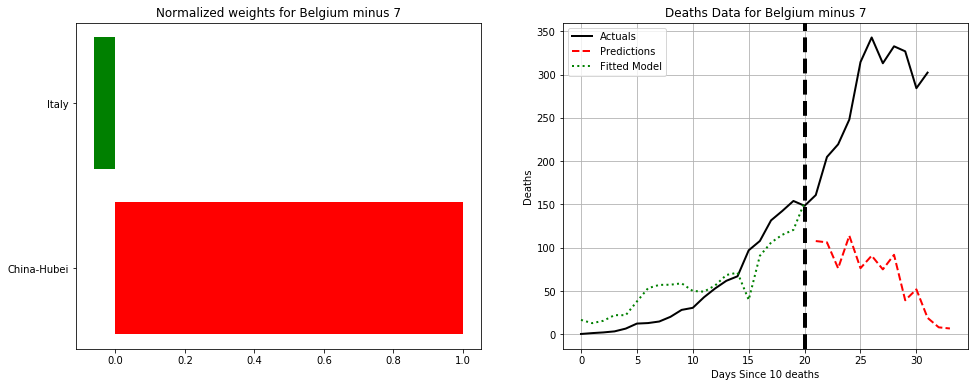

Switzerland    31
dtype: int64
31
['China-Hubei', 'Italy']
['Switzerland']
(21, 255)


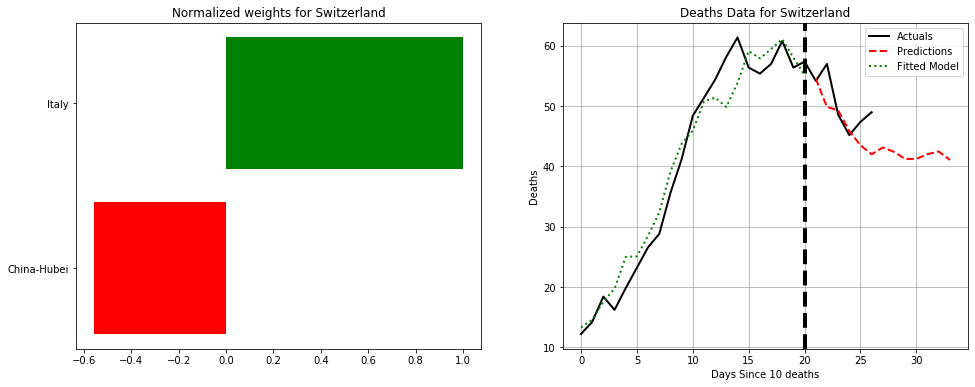

['China-Hubei', 'Italy']
['Switzerland minus 7']
(21, 255)


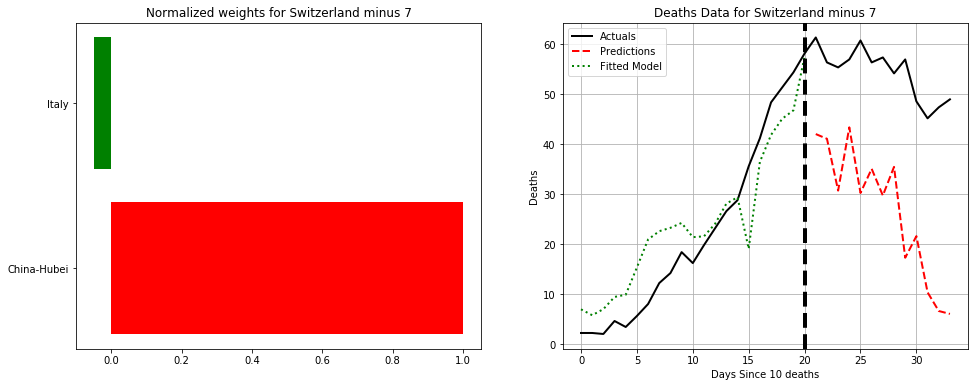

New Jersey    26
dtype: int64
26
['China-Hubei', 'Italy']
['New Jersey']
(21, 255)


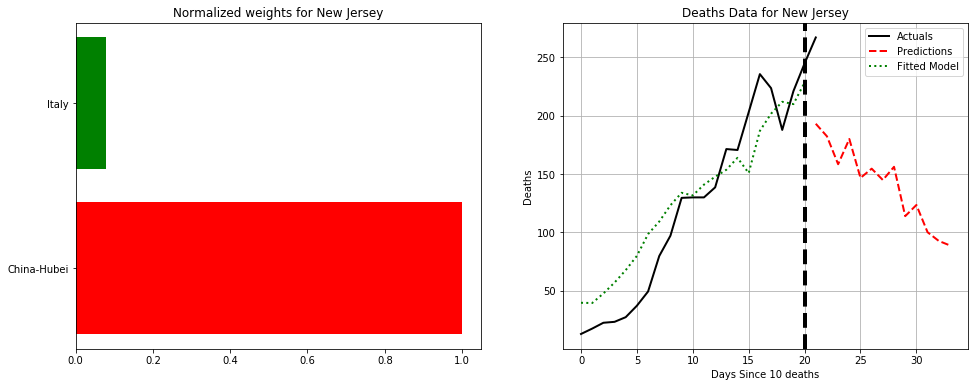

['China-Hubei', 'Italy']
['New Jersey minus 7']
(21, 255)


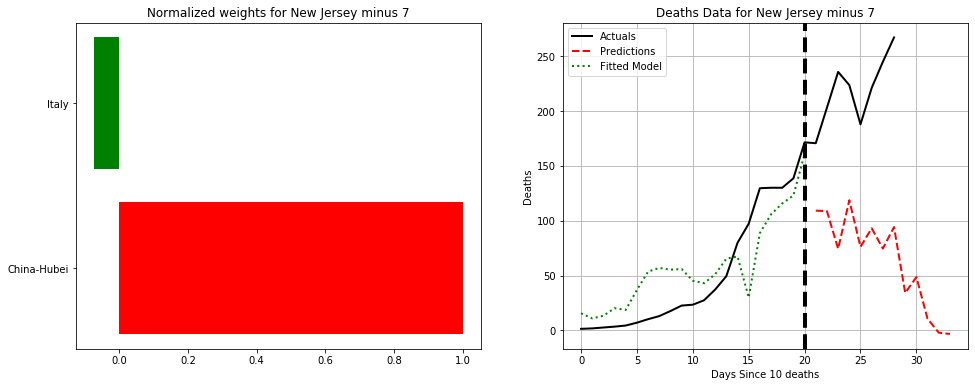

France    33
dtype: int64
33
['China-Hubei', 'Italy']
['France']
(21, 255)


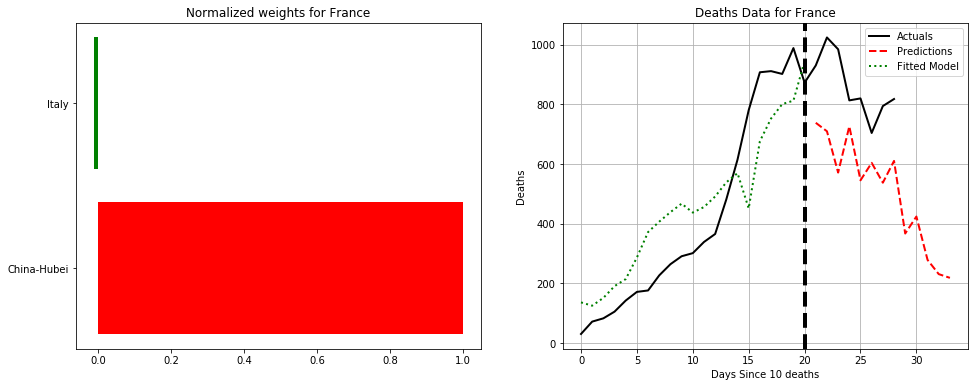

['China-Hubei', 'Italy']
['France minus 7']
(21, 255)


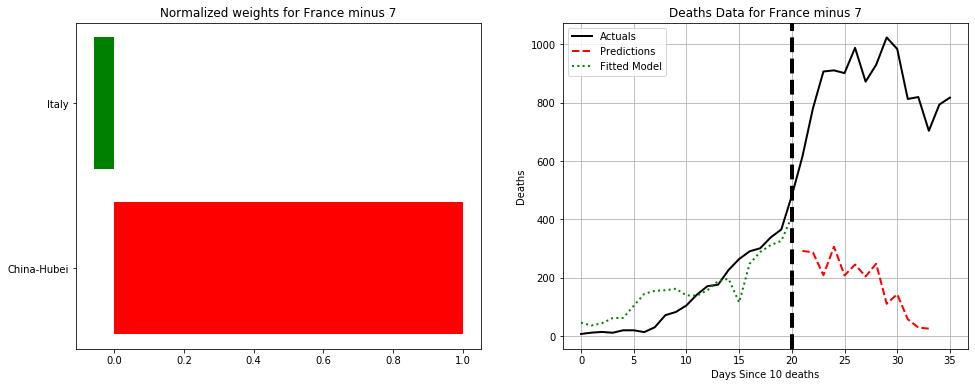

Italy    39
dtype: int64
39
['China-Hubei']
['Italy']
(21, 255)


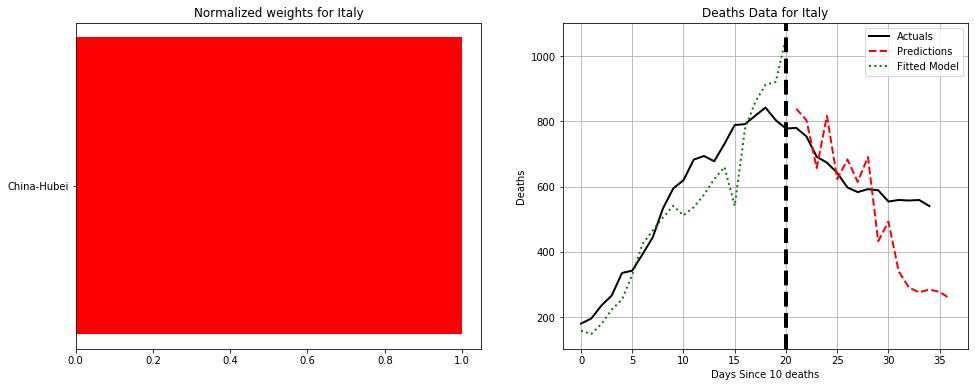

['China-Hubei']
['Italy minus 7']
(21, 255)


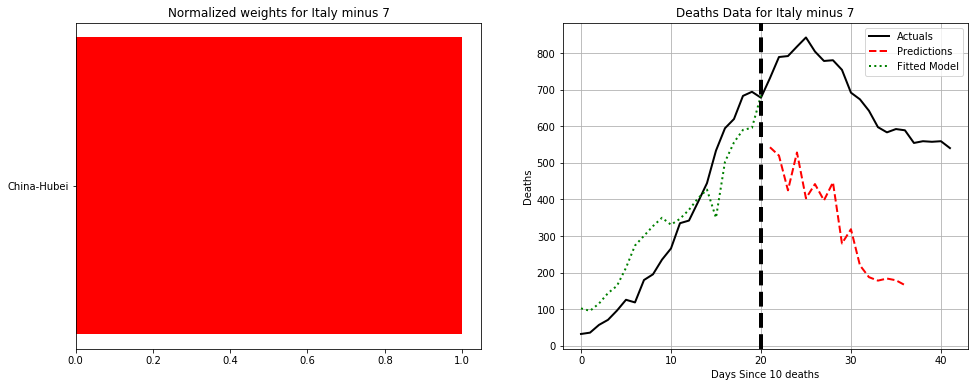

United Kingdom    23
dtype: int64
23
['China-Hubei', 'Italy']
['United Kingdom']
(21, 255)


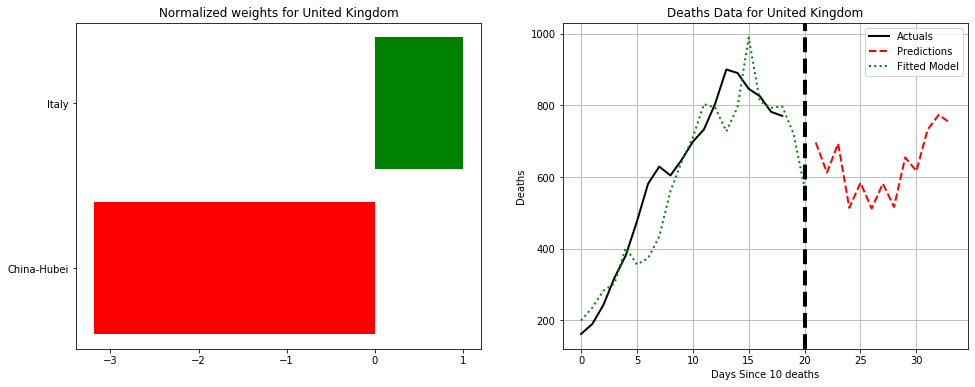

['China-Hubei', 'Italy']
['United Kingdom minus 7']
(21, 255)


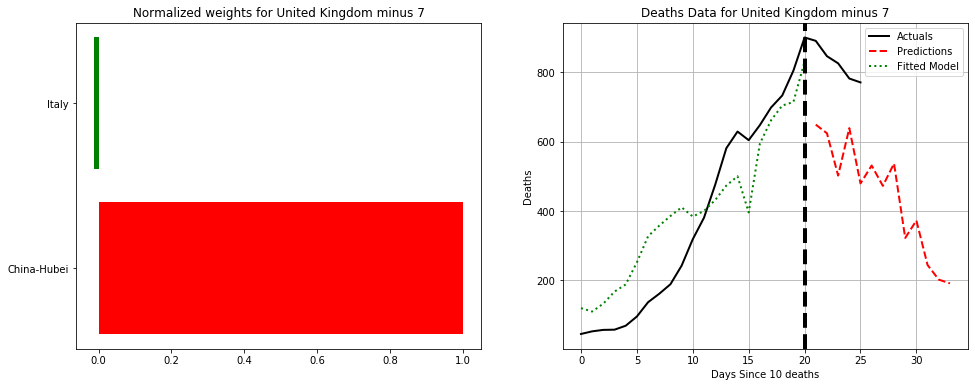

In [16]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
#trial = pd.concat([create_filtered_data(global_deaths, 10), create_filtered_data(usdeaths, 5)], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #sizes = sizes.fillna(0).astype(int)
    print(sizes)
    length = sizes.loc[target]
    print(length)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    #synth_control_predictions2(trial,40,25, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" plus 7"], showstates=10,
    #                           exclude=matching+matching_us)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
    #topstates = synth_control_predictions2(trial,35,length-(rolling_average_duration+2), "Deaths Data", 2, ylimit=[], savePlots=False, exclude=['US'],
                              #          do_only=[target], showstates=8)
    #synth_control_predictions2(trial,35,15, "Deaths Data", 2, ylimit=[], savePlots=False, donorPool=topstates,
                            #do_only=[target], showstates=3)

['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(5, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(6, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7'

<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.

['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(9, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(10, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7

<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.

['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(15, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(16, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 

<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.

['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(21, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 7', 'Slovakia minus 7', 'Slovenia minus 7', 'Spain minus 7', 'Switzerland minus 7', 'King-Washington']
['New York City-New York']
(22, 469)
['Austria minus 7', 'Belgium minus 7', 'Bulgaria minus 7', 'China-Hubei', 'China-Hubei plus 7', 'China-Hubei minus 7', 'Czechia minus 7', 'France minus 7', 'Hungary minus 7', 'Italy', 'Italy minus 7', 'Lithuania minus 7', 'Luxembourg minus 

<ipython-input-2-582314fc772f>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


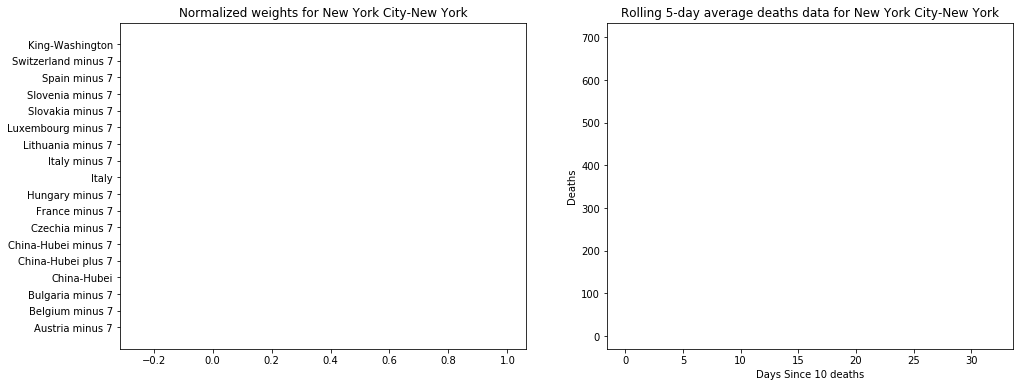

In [17]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
target =  ['New York City-New York']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#target = ['Riverside-California']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
trial = pd.concat([daily_global, daily_uscountines], axis=1)

fig = plt.figure(figsize=(16,6))

camera = Camera(fig)


    


for i in range(20):
    
    #print("Global threshold is ",5, "Counties threshold is ", 2)
    synth_control_predictions2(trial,35,5+i, "Rolling 5-day average deaths data", 2, ylimit=[], savePlots=False, do_only=target, showstates=12,
                               exclude=exclude1, animation=camera)
    #camera.snap()
    #plt.figure(figsize=(16,6))
    #synth_control_predictions2(trial,0,15+i, "Deaths Data", 2, ylimit=[], savePlots=False, 
    #                           exclude=exclude1 + exclude2, do_only=target, showstates=3)
#plt.legend()    
animation = camera.animate()
HTML(animation.to_html5_video())

#animation.save('../New York Western Europe.mp4')

In [36]:
newdf_global = pd.DataFrame()
for i in range(0, 20):
    #usdeaths[usdeaths.index>intervention_date[0]]
    for state in global_deaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            newdata = global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" plus %s"%i], 
            #                                      data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            
            if i == 0:
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state], 
                                                       data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf_global = pd.concat([newdf_global, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


In [38]:
newdf = pd.DataFrame()
for i in range(0,20):
    for state in usdeaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            #newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" plus 7"], 
            #                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=7)][state].values)], axis=1)
            if i == 0:
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state], 
                                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf = pd.concat([newdf, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            #newdf = pd.concat([newdf, pd.DataFrame(columns=[state+"minus 7"], data=usdeaths.loc[usdeaths.index>=intervention_date[0]-7][state].values)], axis=1)


In [39]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [40]:
matching = []
matching_us = []
for i in range(1,20):
    matching = matching + [s for s in newdf_global.columns if str(i) in s]
    matching_us = matching_us + [s for s in newdf.columns if str(i) in s]

print(matching)


['Austria minus 1', 'Belgium minus 1', 'Bulgaria minus 1', 'China-Hubei minus 1', 'Croatia minus 1', 'Cyprus minus 1', 'Czechia minus 1', 'Denmark minus 1', 'Estonia minus 1', 'Finland minus 1', 'France minus 1', 'Georgia minus 1', 'Germany minus 1', 'Greece minus 1', 'Hungary minus 1', 'Iceland minus 1', 'India minus 1', 'Ireland minus 1', 'Italy minus 1', 'Latvia minus 1', 'Lithuania minus 1', 'Luxembourg minus 1', 'Malta minus 1', 'Netherlands minus 1', 'Norway minus 1', 'Poland minus 1', 'Portugal minus 1', 'Romania minus 1', 'Slovakia minus 1', 'Slovenia minus 1', 'Spain minus 1', 'Sweden minus 1', 'Switzerland minus 1', 'United Kingdom minus 1', 'Austria minus 10', 'Belgium minus 10', 'Bulgaria minus 10', 'China-Hubei minus 10', 'Croatia minus 10', 'Cyprus minus 10', 'Czechia minus 10', 'Denmark minus 10', 'Estonia minus 10', 'Finland minus 10', 'France minus 10', 'Georgia minus 10', 'Germany minus 10', 'Greece minus 10', 'Hungary minus 10', 'Iceland minus 10', 'India minus 10', 

In [41]:
rolling_average_duration = 5

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

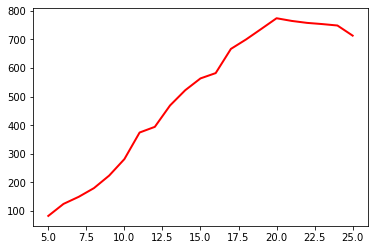

In [42]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

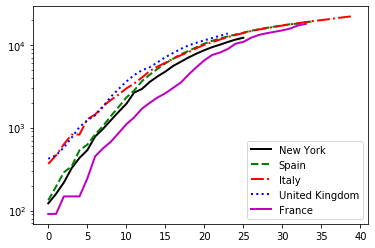

(<matplotlib.axes._subplots.AxesSubplot at 0x123eef520>,
 <matplotlib.legend.Legend at 0x1249c8640>)

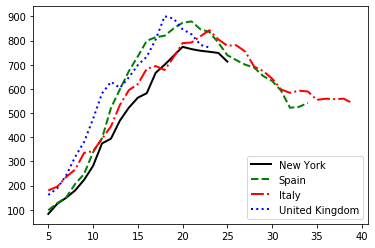

In [43]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

['China-Hubei', 'Italy']
['Ohio']
(21, 1700)


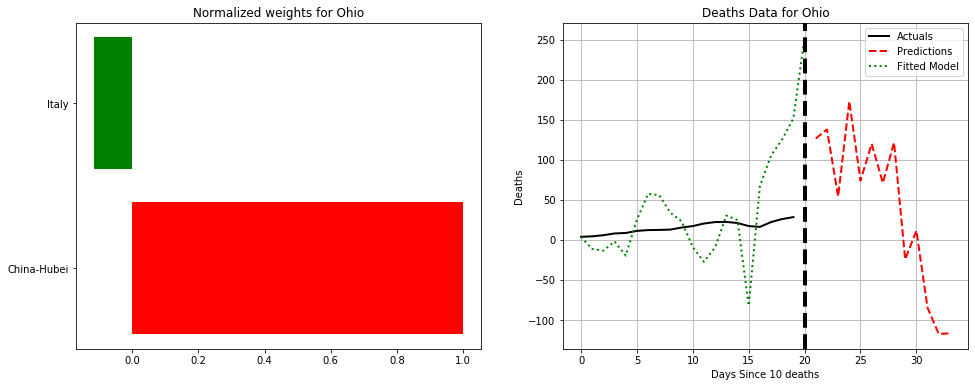

['China-Hubei', 'Italy']
['Ohio minus 7']
(21, 1700)


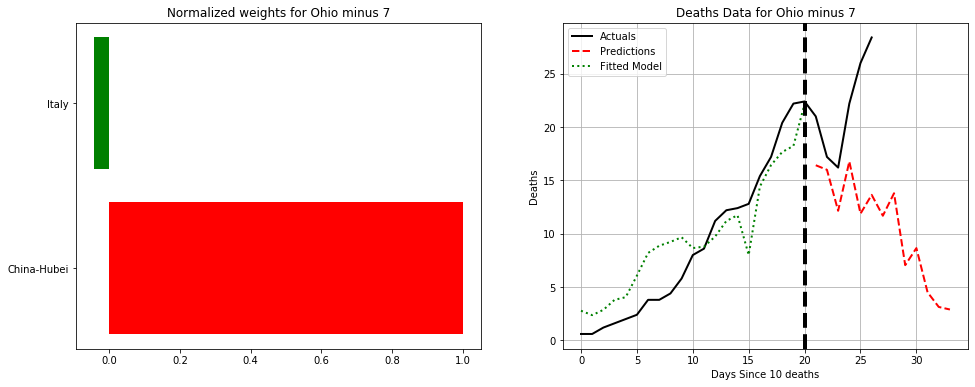

['China-Hubei', 'Italy']
['New York']
(21, 1700)


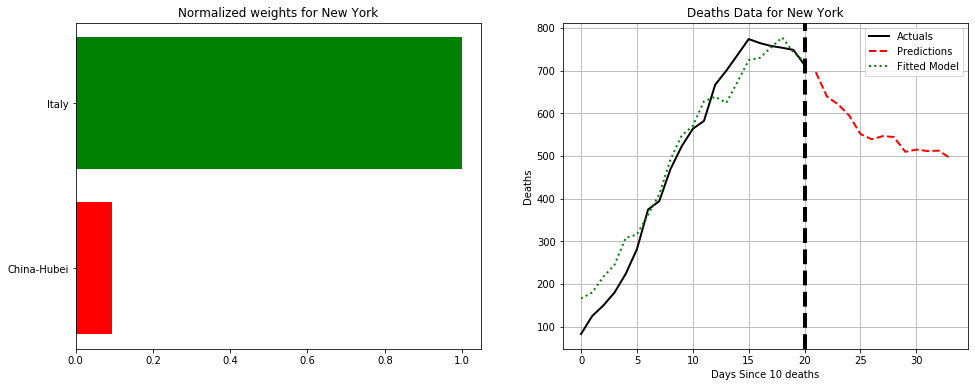

['China-Hubei', 'Italy']
['New York minus 7']
(21, 1700)


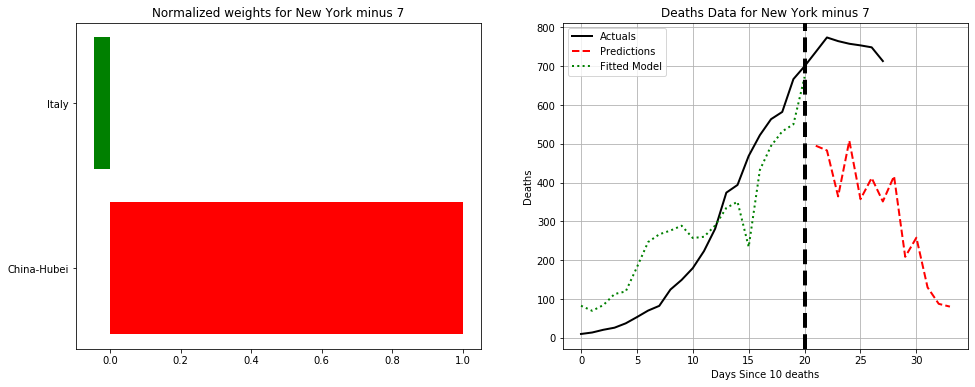

['China-Hubei', 'Italy']
['Illinois']
(21, 1700)


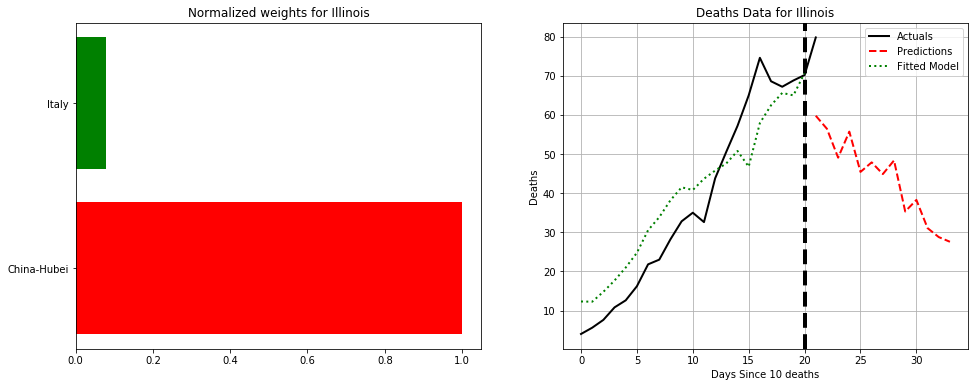

['China-Hubei', 'Italy']
['Illinois minus 7']
(21, 1700)


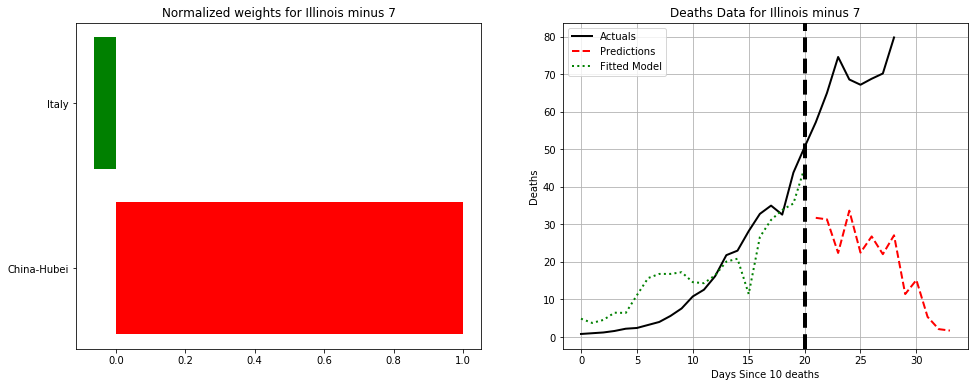

['China-Hubei', 'Italy']
['Belgium']
(21, 1700)


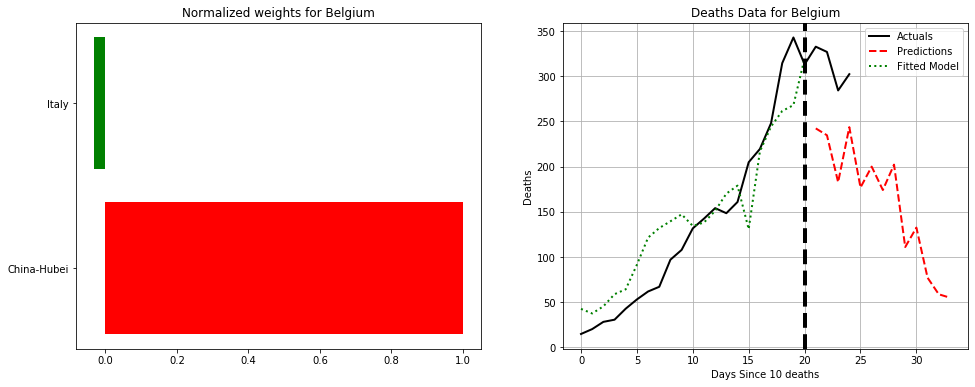

['China-Hubei', 'Italy']
['Belgium minus 7']
(21, 1700)


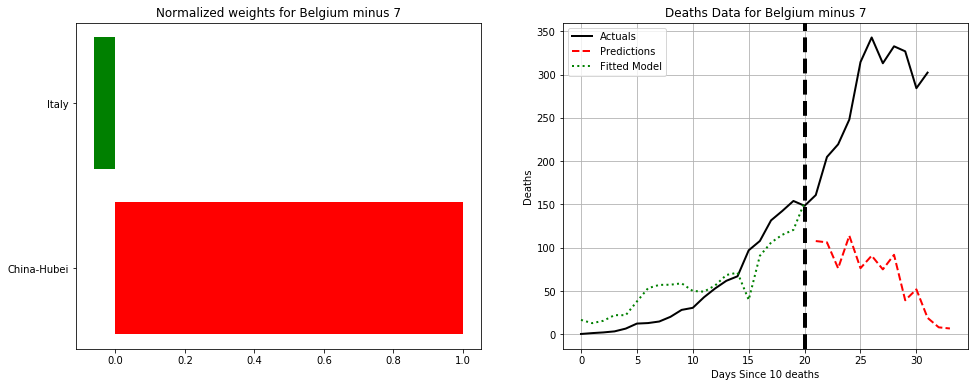

['China-Hubei', 'Italy']
['Switzerland']
(21, 1700)


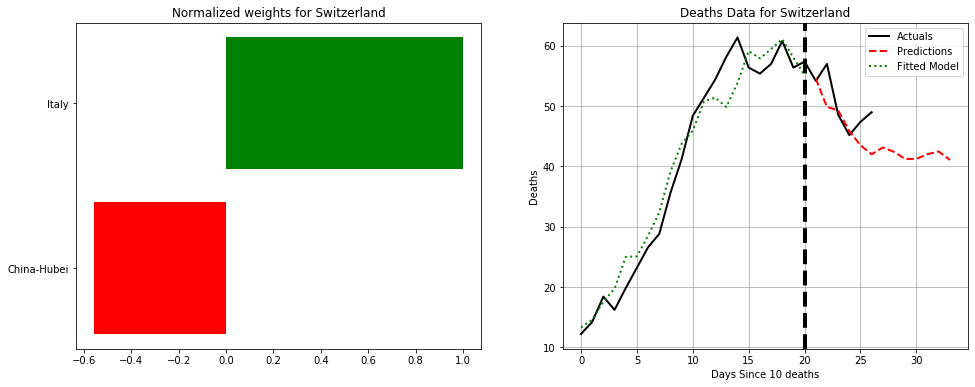

['China-Hubei', 'Italy']
['Switzerland minus 7']
(21, 1700)


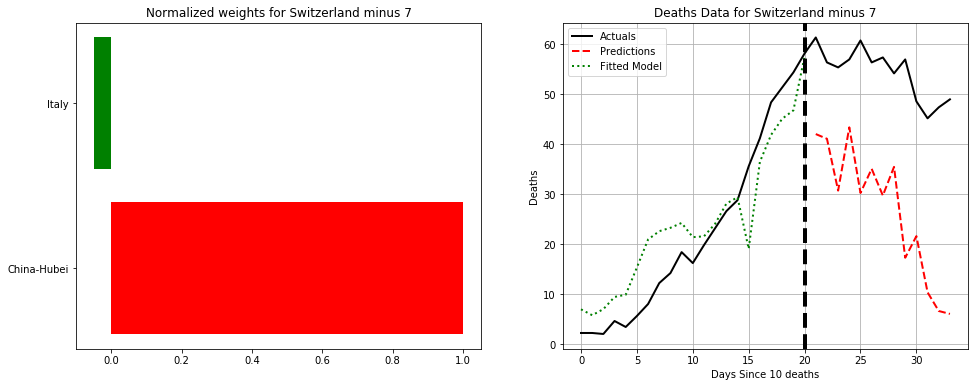

['China-Hubei', 'Italy']
['New Jersey']
(21, 1700)


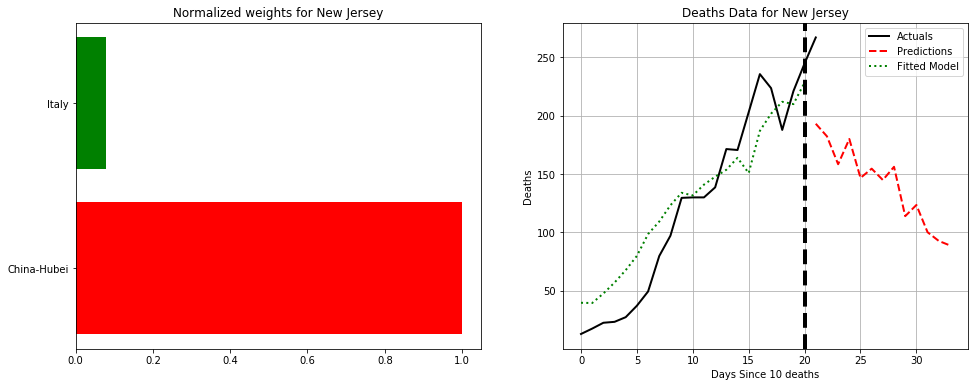

['China-Hubei', 'Italy']
['New Jersey minus 7']
(21, 1700)


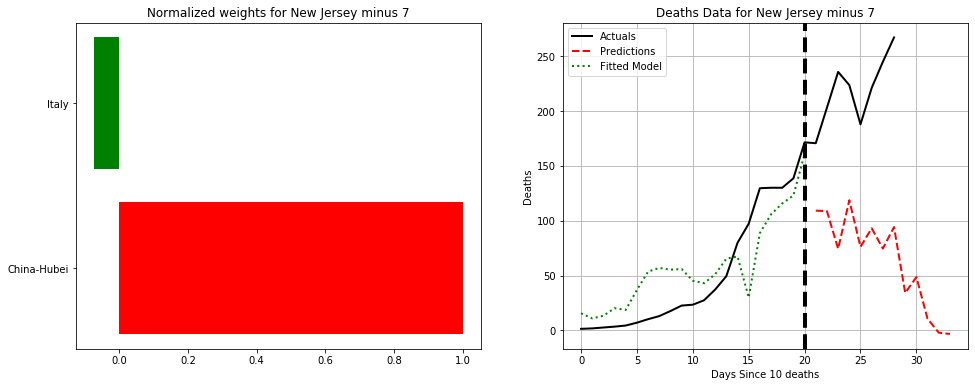

['China-Hubei', 'Italy']
['France']
(21, 1700)


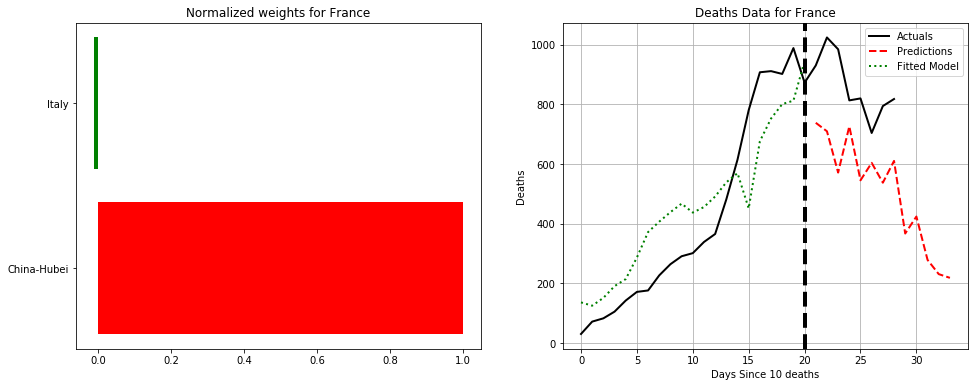

['China-Hubei', 'Italy']
['France minus 7']
(21, 1700)


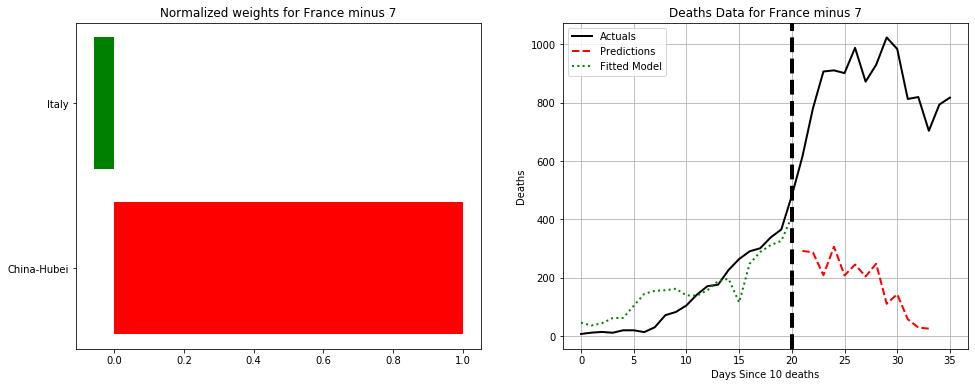

['China-Hubei']
['Italy']
(21, 1700)


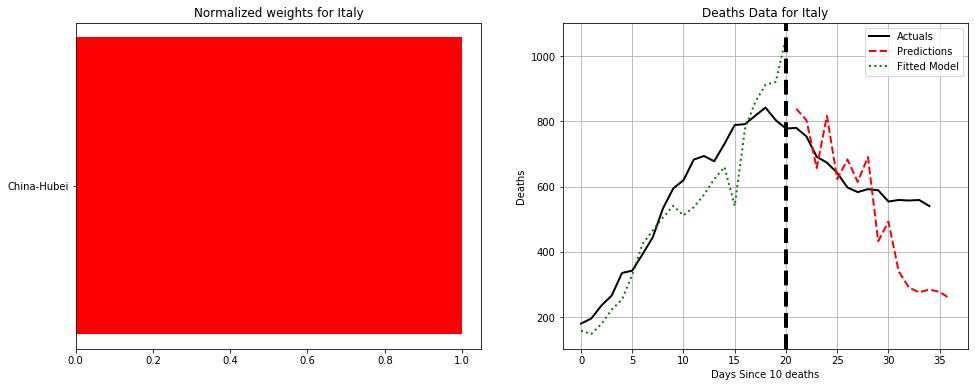

['China-Hubei']
['Italy minus 7']
(21, 1700)


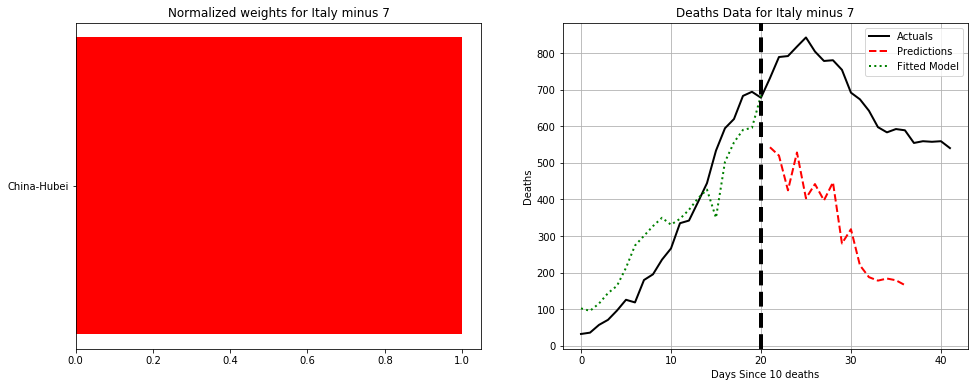

['China-Hubei', 'Italy']
['United Kingdom']
(21, 1700)


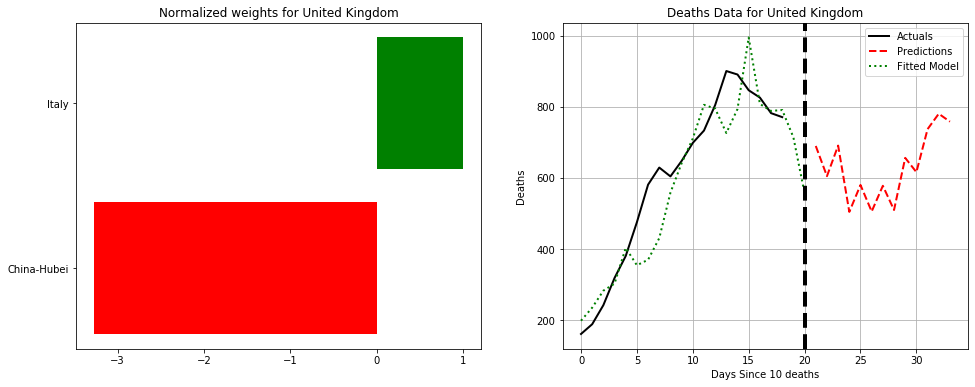

['China-Hubei', 'Italy']
['United Kingdom minus 7']
(21, 1700)


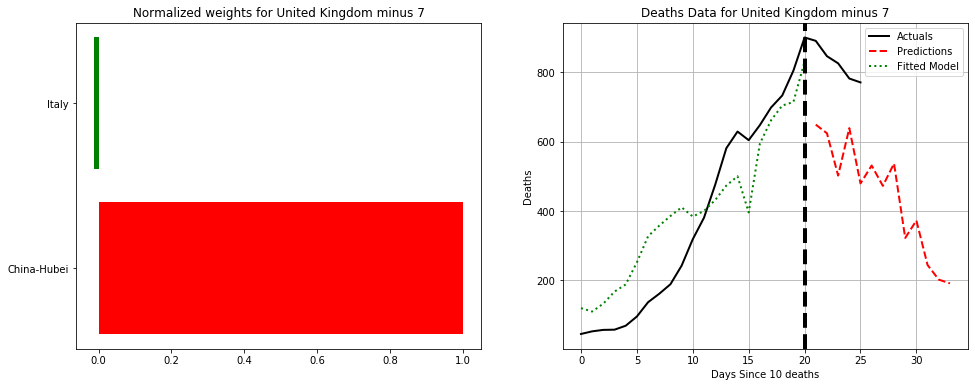

In [55]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
#trial = pd.concat([create_filtered_data(global_deaths, 10), create_filtered_data(usdeaths, 5)], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #print(sizes)
    length = sizes.loc[target]
    #print(length)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
   


['China-Hubei', 'Italy']
['New York minus 1']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 2']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 3']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 4']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 5']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 6']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 7']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 8']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 9']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 10']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 11']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 12']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 13']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 14']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 15']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 16']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 17']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 18']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 19']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

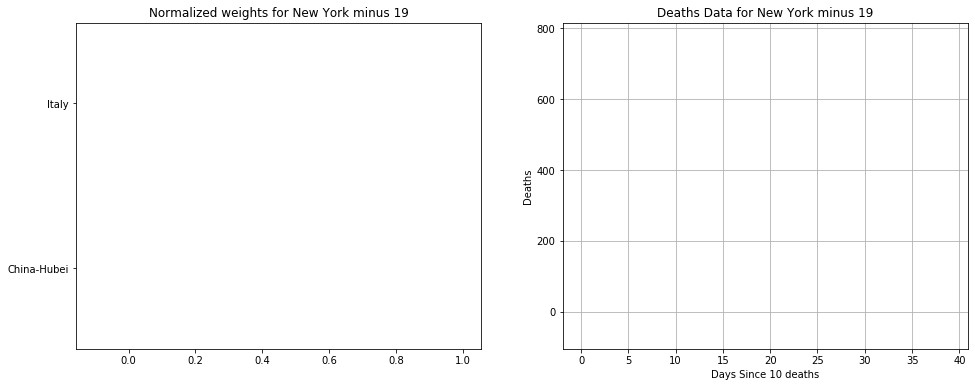

In [60]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
target =  ['New York']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#target = ['Riverside-California']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)
fig = plt.figure(figsize=(16,6))

camera = Camera(fig)
singVals =3

    


for i in range(1,20):
    
    #print("Global threshold is ",5, "Counties threshold is ", 2)
    synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target[0]+" minus %s"%i], showstates=12,
                               exclude=matching+matching_us, animation=camera)
    #synth_control_predictions2(trial,38,21, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
    #                          exclude=matching+matching_us+[target])
    #camera.snap()
    #plt.figure(figsize=(16,6))
    #synth_control_predictions2(trial,0,15+i, "Deaths Data", 2, ylimit=[], savePlots=False, 
    #                           exclude=exclude1 + exclude2, do_only=target, showstates=3)
#plt.legend()    
animation = camera.animate()
HTML(animation.to_html5_video())

#animation.save('../New York Western Europe.mp4')

['China-Hubei', 'Italy']
['New York minus 1']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 2']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 3']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 4']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 5']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 6']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 7']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 8']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 9']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 10']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 11']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 12']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 13']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 14']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 15']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 16']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

['China-Hubei', 'Italy']
['New York minus 17']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 18']
(21, 1700)
['China-Hubei', 'Italy']
['New York minus 19']
(21, 1700)


<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-46-04f8a70b0554>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


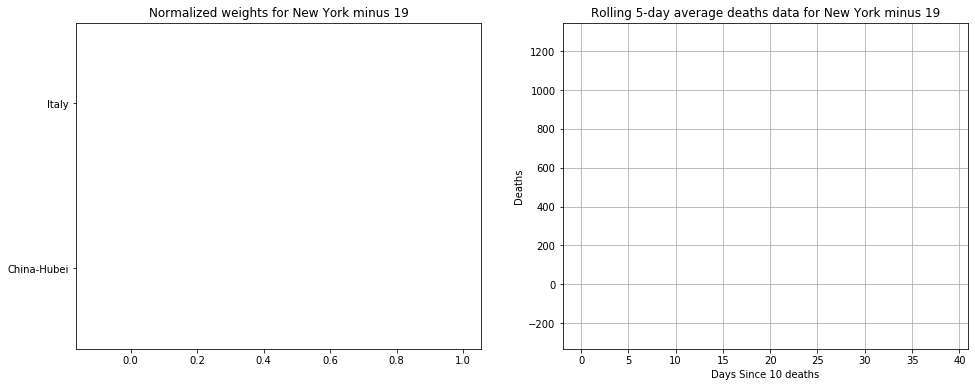

In [72]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
targets =  ['New York']#'Italy', 'France', 'United Kingdom', 'New York', 'Spain', 'Switzerland']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#targets = ['Switzerland', 'Belgium']# 'Netherlands']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)

#fig = plt.figure(figsize=(16,6))
#camera = Camera(fig)
singVals =2  

   

for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,20):
        synth_control_predictions2(trial,38,21, "Rolling 5-day average deaths data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus %s"%i], showstates=12,
                                   exclude=matching+matching_us, animation=camera)
animation = camera.animate()

HTML(animation.to_html5_video())

    #animation.save('../animations/'+target+" no donors shown"'.mp4')
